In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob

from skimage import io as skio
import pandas as pd
import statsmodels.formula.api as smf

In [3]:
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14

In [4]:
imgs = {}
data = pd.DataFrame()
for img_id, f in enumerate(glob('data/cropped/resized/*.jpg')):
    weight = float(f.split('\\')[-1].split('g')[0])
    data[img_id] = pd.Series({'weight': weight})
    imgs[img_id] = skio.imread(f)
    
data = data.T
data['img'] = data.index

In [5]:
data

,weight,img
0,10.59,0
1,11.69,1
2,16.00,2
3,16.05,3
4,17.77,4
5,19.34,5
6,21.23,6
7,23.27,7
8,28.99,8
9,30.77,9


In [20]:
data.weight.sum()

195.70000000000002

In [6]:
halfpoint = imgs[0].shape[0] // 2

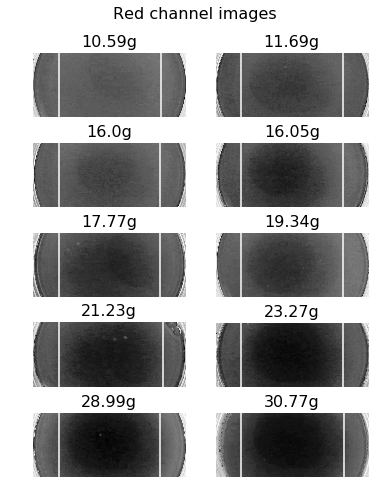

In [29]:
figsize(6, 8)
for i in data.index:
    plt.subplot((len(imgs) + 1) // 2, 2, i + 1)
    plt.imshow(imgs[i][halfpoint - 250:halfpoint + 250, :, 0], cmap=cm.Greys_r)
    plt.title('{}g'.format(data.loc[i, 'weight']))
    plt.axis('off')
    plt.axvline(200, c='w')
    plt.axvline(1000, c='w')
    
plt.suptitle('Red channel images', fontsize=16, y=0.95)
plt.savefig('figures/red_channel_images.png', bbox_nches='tight');

In [40]:
from sklearn.preprocessing import minmax_scale as scale

In [41]:
colors = cm.OrRd(scale(data.weight))

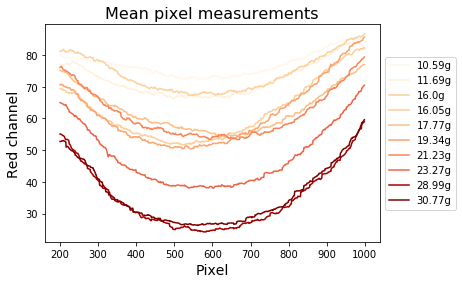

In [49]:
figsize(6, 4)
for i in data.img:
    plt.plot(np.arange(200, 1000),
             imgs[i][halfpoint - 250:halfpoint + 250, 200:1000, 0].mean(0),
             c=colors[i], label='{}g'.format(data.loc[i, 'weight']))
    
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Pixel')
plt.ylabel('Red channel');
plt.title('Mean pixel measurements');
plt.savefig('figures/mean-pixel-measurements.png', bbox_inches='tight', bbox_extra_artists=(lgd,));

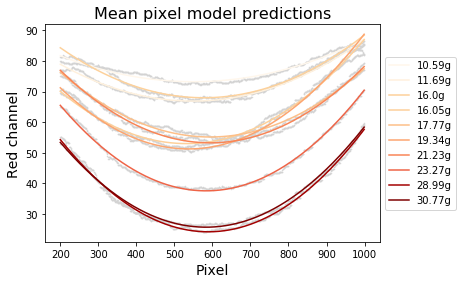

In [59]:
figsize(6, 4)

for i in data.img:
    plt.scatter(np.arange(200, 1000),
             imgs[i][halfpoint - 250:halfpoint + 250, 200:1000, 0].mean(0), c='lightgrey', marker='.', s=1)

for i in data.index:
    img_data = pd.DataFrame(
    {
        'pixel': np.arange(200, 1000),
        'intensity': imgs[i][halfpoint - 250:halfpoint + 250, 200:1000, 0].mean(0)
    })
    res = smf.ols('intensity ~ I(pixel ** 2) + pixel + 1', img_data).fit()
    preds = res.predict(img_data)
    plt.plot(img_data.pixel, preds,
             c=colors[i], label='{}g'.format(data.loc[i, 'weight']))
    
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Pixel')
plt.ylabel('Red channel');
plt.title('Mean pixel model predictions');
plt.savefig('figures/mean-pixel-model-predictions.png', bbox_inches='tight', bbox_extra_artists=(lgd,));

In [11]:
import os.path
import time

In [12]:
for f in glob('data/*.jpg'):
    print(time.ctime(os.path.getmtime(f)))

Mon Jan  9 09:12:58 2017
Wed Jan 11 14:27:08 2017
Tue Jan 10 09:12:44 2017
Thu Jan 12 16:08:37 2017
Mon Jan  9 10:18:02 2017
Fri Jan 13 09:10:22 2017
Mon Jan  9 15:41:45 2017
Tue Jan 10 10:20:17 2017
Wed Jan 11 09:19:18 2017
Thu Jan 12 11:37:17 2017


In [13]:
import io

In [14]:
table = '''
weight	rings	hour	day
10.59	11	9	9
11.69	12	14	11
16	13	9	10
16.05	12	16	12
17.77	15	10	9
19.34	12	9	13
21.23	13	15	9
23.27	11	10	10
28.99	13	9	11
30.77	10	11	12
'''

df = pd.read_table(io.StringIO(table))
df

,weight,rings,hour,day
0,10.59,11,9,9
1,11.69,12,14,11
2,16.00,13,9,10
3,16.05,12,16,12
4,17.77,15,10,9
5,19.34,12,9,13
6,21.23,13,15,9
7,23.27,11,10,10
8,28.99,13,9,11
9,30.77,10,11,12


In [15]:
df = data.merge(df, on='weight', ).sort_values('weight')
df

,weight,img,min_intensity,rings,hour,day
0,10.59,0,73.230380,11,9,9
1,11.69,1,66.898472,12,14,11
2,16.00,2,67.990016,13,9,10
3,16.05,3,53.005938,12,16,12
4,17.77,4,55.164411,15,10,9
5,19.34,5,51.260926,12,9,13
6,21.23,6,53.252176,13,15,9
7,23.27,7,37.564049,11,10,10
8,28.99,8,24.175831,13,9,11
9,30.77,9,25.684275,10,11,12


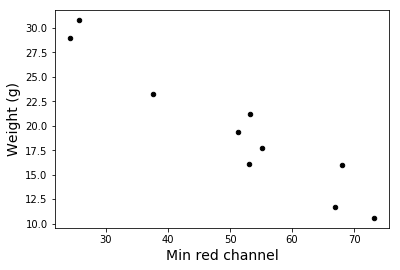

In [16]:
figsize(6, 4)
df.plot(x='min_intensity', y='weight', kind='scatter', c='k');
plt.xlabel('Min red channel')
plt.ylabel('Weight (g)');

In [61]:
mod = smf.ols('weight ~ min_intensity', df)
res = mod.fit()

In [62]:
res.summary()

C:\Users\vale\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     95.68
Date:                Sun, 05 Feb 2017   Prob (F-statistic):           1.00e-05
Time:                        17:17:19   Log-Likelihood:                -19.847
No. Observations:                  10   AIC:                             43.69
Df Residuals:                       8   BIC:                             44.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        38.7523      2.057     18.835      0.000        34.008    43.497
min_intensity    -0.3774      0.039     -9.782      0.000        -0.466    -0.288
==============================================================================
Omnibus:                        0.679   Durbin-Watson:                   2.897
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.620
Skew:                           0.341   Prob(JB):                        0.734
Kurtosis:                       1.989   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

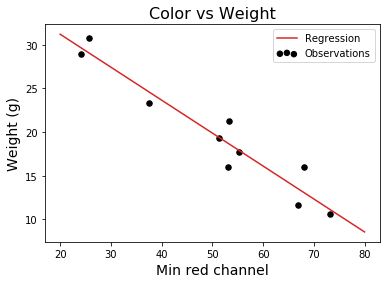

In [65]:
xx = np.linspace(20., 80.)
yy = res.predict(pd.DataFrame({'min_intensity': xx}))

figsize(6, 4)
df.plot(x='min_intensity', y='weight', kind='scatter', c='k', s=30, label='Observations');
plt.plot(xx, yy, c='tab:red', label='Regression');

plt.xlabel('Min red channel')
plt.ylabel('Weight (g)');

plt.title('Color vs Weight');

plt.legend(scatterpoints=3);
plt.savefig('figures/color-vs-weight.png')